In [2]:
import cv2
import numpy as np
from google.colab import files
from google.colab.patches import cv2_imshow
import tensorflow as tf

In [3]:
model = tf.keras.models.load_model('fashion_classifier_model.h5')

Saving bottomwear_shorts2281.png to bottomwear_shorts2281 (1).png
1/1 [==============================] - 0s 134ms/step


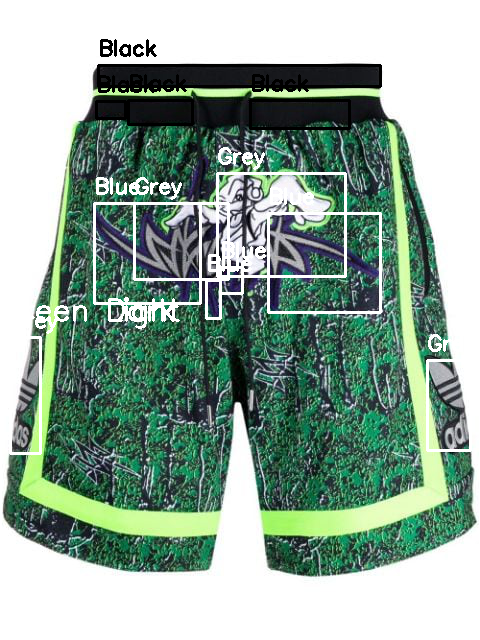

Predicted outfit label: Short - Colors: Black, Grey, Green Dark, Green Light, Blue
Confidence score (accuracy): 100.00%


In [9]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from tensorflow import keras
import tensorflow as tf
from google.colab import files

# Dictionary for mapping class indices to labels
types_dict = ['Blazer', 'Dress', 'Jacket', 'Pants', 'Shirt', 'Short', 'Skirt', 'Top', 'Tshirt']

def create_outfit_mask(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, binary = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    return binary
def detect_colors(input_image):
    # Create outfit mask
    outfit_mask = create_outfit_mask(input_image)

    # Convert image to HSV
    hsv = cv2.cvtColor(input_image, cv2.COLOR_BGR2HSV)

    # Define color ranges in HSV
    color_ranges = {
        "Red": ([0, 100, 100], [10, 255, 255]),  # Lower range for red
        "Red": ([160, 100, 100], [180, 255, 255]),  # Higher range for red (because red wraps around in HSV)
        "Blue": ([90, 100, 70], [130, 255, 255]),  # Adjusted range for dark blue
        "Yellow Bright": ([20, 100, 100], [30, 255, 255]),  # Bright yellow range
        "Yellow Dark": ([20, 100, 50], [30, 255, 255]),  # Dark yellow range
        "Green Dark": ([40, 100, 70], [80, 255, 255]),  # Dark green range
        "Green Light": ([40, 100, 100], [80, 255, 255]),  # Light green range
        "Pink": ([140, 100, 200], [170, 255, 255]),  # Adjusted range for bright pink
        "Purple": ([130, 50, 100], [150, 255, 255]),  # Adjusted range for light purple
        "Brown": ([10, 100, 50], [20, 255, 150]),  # Adjusted range for dark brown
        "Black": ([0, 0, 0], [180, 50, 30]),  # Narrowed range for black
        "White": ([0, 0, 230], [180, 20, 255]),  # Adjusted range for bright white
        "Grey": ([0, 0, 90], [180, 20, 200]),  # Narrowed range for grey
        "Cream": ([20, 100, 200], [40, 50, 255])  # Adjusted range for cream
    }

    detected_colors = set()

    for color_name, (lower, upper) in color_ranges.items():
        lower = np.array(lower)
        upper = np.array(upper)
        mask = cv2.inRange(hsv, lower, upper)

        # Apply the outfit mask
        mask = cv2.bitwise_and(mask, mask, mask=outfit_mask)

        # Apply morphology to clean up the mask
        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

        # Calculate the total number of pixels for the current color
        color_pixels = cv2.countNonZero(mask)

        # Define the threshold for dominance (e.g., 10% of total image pixels)
        dominance_threshold = 0.1 * input_image.shape[0] * input_image.shape[1]

        if color_pixels > dominance_threshold:
            # Draw a large bounding box
            x, y, w, h = 0, 0, input_image.shape[1], input_image.shape[0]
            color_code = (0, 0, 0) if color_name == "Black" else (255, 255, 255)
            cv2.putText(input_image, color_name, (x, y + h // 2), cv2.FONT_HERSHEY_SIMPLEX, 1, color_code, 2)
            cv2.rectangle(input_image, (x, y), (x + w, y + h), color_code, 2)
            detected_colors.add(color_name)
        else:
            # Draw a small bounding box around detected objects
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            for contour in contours:
                area = cv2.contourArea(contour)
                if area > 100:
                    x, y, w, h = cv2.boundingRect(contour)
                    detected_colors.add(color_name)
                    y_pos = y - 10 if y - 10 > 10 else y + 20
                    color_code = (0, 0, 0) if color_name == "Black" else (255, 255, 255)
                    cv2.putText(input_image, color_name, (x, y_pos), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color_code, 2)
                    # Draw bounding box with color matching the detected color
                    cv2.rectangle(input_image, (x, y), (x + w, y + h), color_code, 2)

    return input_image, list(detected_colors)

def predict_outfit(model, img_path, types_dict):
    img = tf.keras.utils.load_img(img_path, target_size=(150, 150))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    predicted_label = types_dict[predicted_class]

    confidence_score = predictions[0][predicted_class] * 100

    return predicted_label, confidence_score

# Upload image file in Colab
uploaded = files.upload()

# Get the first uploaded image file
image_files = list(uploaded.keys())
if not image_files:
    print("No image file uploaded.")
else:
    # Take the first uploaded image
    image_path = image_files[0]

    # Read the uploaded image
    img = cv2.imread(image_path)

    # Detect colors
    processed_img, detected_colors = detect_colors(img)

    # Predict outfit
    model = keras.models.load_model('/content/fashion_classifier_model.h5')  # Load your trained model
    outfit_label, confidence_score = predict_outfit(model, image_path, types_dict)

    # Combine outfit label with detected colors
    detected_colors_text = ', '.join(detected_colors)
    final_label = f'{outfit_label} - Colors: {detected_colors_text}'
    cv2_imshow(processed_img)
    print(f'Predicted outfit label: {final_label}')
    print("Confidence score (accuracy): {:.2f}%".format(confidence_score))